In [507]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import geopandas as gpd

In [508]:
#data read/create dfs
prices_df = pd.read_csv('raw-data/egg-prices.csv')
production_df = pd.read_csv('raw-data/egg-production.csv')

Exploratory Data Analysis for Egg Prices

Summary:
- 72 rows, 9 columns.
- No values in columns 'LOCATION', 'STATE ANSI', 'ASD CODE', 'COUNTY ANSI'.
- The average all utilization price is approximately 0.90 $/dozen (minimum: 0.483, maximum: 1.89).
- Row count as expected for data from 2016-2021. 6 years x 12 months =  72 rows.

In [509]:
#eda for prices_df
print(prices_df.head())
print(prices_df.tail())
print(prices_df.shape)
print(prices_df.columns)
print(prices_df.dtypes)
print(prices_df.describe(include='all'))

   YEAR  LOCATION STATE ANSI ASD CODE COUNTY ANSI REFERENCE PERIOD COMMODITY  \
0  2016  US TOTAL                                              JAN      EGGS   
1  2016  US TOTAL                                              FEB      EGGS   
2  2016  US TOTAL                                              MAR      EGGS   
3  2016  US TOTAL                                              APR      EGGS   
4  2016  US TOTAL                                              MAY      EGGS   

   ALL UTILIZATION PRACTICES in $ / DOZEN  \
0                                   1.180   
1                                   1.080   
2                                   0.970   
3                                   0.680   
4                                   0.552   

   ALL UTILIZATION PRACTICES, TABLE in $ / DOZEN  
0                                          0.969  
1                                          0.850  
2                                          0.731  
3                                          0

In [510]:
#examining nulls
print(prices_df.isnull().sum())

YEAR                                             0
LOCATION                                         0
STATE ANSI                                       0
ASD CODE                                         0
COUNTY ANSI                                      0
REFERENCE PERIOD                                 0
COMMODITY                                        0
ALL UTILIZATION PRACTICES in $ / DOZEN           0
ALL UTILIZATION PRACTICES, TABLE in $ / DOZEN    0
dtype: int64


Exploratory Data Analysis for Egg Production

Summary:
- 8,212 rows, 21 columns.
- 9 empty columns.
- 'State ANSI' has null rows. These were explored more and handled during cleaning.
- Several rows contain "(D)". These represent redacted data according to USDA quick stats database guide. This resulted in incomplete state data.
- Value dtype is object. The column contains integers.

In [511]:
#eda for production_df
print(production_df.head())
print(production_df.tail())
print(production_df.shape)
print(production_df.columns)
print(production_df.dtypes)
print(production_df.describe(include='all'))

  Program  Year Period  Week Ending Geo Level     State  State ANSI  \
0  SURVEY  2021    APR          NaN     STATE   ALABAMA         1.0   
1  SURVEY  2021    APR          NaN     STATE   ALABAMA         1.0   
2  SURVEY  2021    APR          NaN     STATE   ALABAMA         1.0   
3  SURVEY  2021    APR          NaN     STATE   ALABAMA         1.0   
4  SURVEY  2021    APR          NaN     STATE  ARKANSAS         5.0   

   Ag District  Ag District Code  County  ...  Zip Code  Region  \
0          NaN               NaN     NaN  ...       NaN     NaN   
1          NaN               NaN     NaN  ...       NaN     NaN   
2          NaN               NaN     NaN  ...       NaN     NaN   
3          NaN               NaN     NaN  ...       NaN     NaN   
4          NaN               NaN     NaN  ...       NaN     NaN   

   watershed_code  Watershed  Commodity  \
0               0        NaN       EGGS   
1               0        NaN       EGGS   
2               0        NaN       EGGS  

In [512]:
#examining nulls
print(production_df.isnull().sum())

Program                0
Year                   0
Period                 0
Week Ending         8212
Geo Level              0
State                  0
State ANSI           288
Ag District         8212
Ag District Code    8212
County              8212
County ANSI         8212
Zip Code            8212
Region              8212
watershed_code         0
Watershed           8212
Commodity              0
Data Item              0
Domain                 0
Domain Category        0
Value                  0
CV (%)              8212
dtype: int64


Cleans `production_df` by removing unnecessary or empty columns, dropping rows with '(D)' in the 'Value' column (indicating no data), converting the 'Value' column to integers, removing rows for 'OTHER STATES', filtering for data measured in dozens, converting 'State ANSI' to integer type, and renaming columns for clarity and consistency.

In [513]:
#drop unneccessary and empty columns
production_df = production_df.drop(columns=['Program', 'Week Ending', 'Ag District', 'Geo Level', 'Ag District Code', 'County', 'County ANSI', 'Zip Code', 'Region', 'watershed_code', 
                                            'Watershed', 'Commodity', 'Domain', 'Domain Category', 'CV (%)'])

#drop rows with (D) under Value column, represents no data. strip used because there is a space in front of (D).
production_df = production_df[production_df['Value'].str.strip() != '(D)']

#changing 'Value' column dtype to int instead of object for later calculations.
production_df['Value'] = production_df['Value'].str.replace(',', '').astype(int)

#'State ANSI' nulls represent 'OTHER STATES' in 'State' column, dropping these rows
production_df = production_df[production_df['State'] != 'OTHER STATES']

#need to match unit of measurement with prices_df, removing rows not measured by the dozen.
production_df = production_df[~production_df['Data Item'].str.contains('MEASURED IN EGGS')]

#'State Ansi' dtype change from float64 to int64 to remove decimals
production_df['State ANSI'] = production_df['State ANSI'].astype(int)

#rename columns for clarity and consistency
production_df.columns = ['Year', 'Month', 'State', 'State Identifier', 'Egg Type', 'Production in Dozens']

#verify
print(production_df.head())


    Year Month     State  State Identifier  \
0   2021   APR   ALABAMA                 1   
2   2021   APR   ALABAMA                 1   
16  2021   APR   GEORGIA                13   
18  2021   APR   GEORGIA                13   
20  2021   APR  ILLINOIS                17   

                                          Egg Type  Production in Dozens  
0   EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN              13241700  
2      EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN               3025000  
16  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN              15958400  
18     EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN              19200000  
20  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN                291700  


Cleans `prices_df`. Empty columns removed. Remaining columns renamed for clarity and consistency.

In [514]:
#drop empty columns
prices_df = prices_df.drop(columns=['LOCATION', 'STATE ANSI', 'ASD CODE', 'COUNTY ANSI', 'COMMODITY'])

#rename columns for clarity and consistency
prices_df.columns = ['Year', 'Month', 'Price($) per Dozen (All Types)', 'Price per Dozen (Table)']

#verify
print(prices_df.head())

   Year Month  Price($) per Dozen (All Types)  Price per Dozen (Table)
0  2016   JAN                           1.180                    0.969
1  2016   FEB                           1.080                    0.850
2  2016   MAR                           0.970                    0.731
3  2016   APR                           0.680                    0.391
4  2016   MAY                           0.552                    0.242


Creates SQLite database `egg_data.db`. `production` table created based on `production_df` and `prices` table created based on `prices_df`.

In [515]:
#create connection
conn = sqlite3.connect('egg_data.db')
cursor = conn.cursor()

#create production table
cursor.execute("""
CREATE TABLE IF NOT EXISTS production (
    Year INTEGER,
    Month TEXT,
    State TEXT,
    "State Identifier" INTEGER,
    "Egg Type" TEXT,
    "Production in Dozens" INTEGER,
    PRIMARY KEY (Year, Month)
)
""")

#create prices table
cursor.execute("""
CREATE TABLE IF NOT EXISTS prices (
    Year INTEGER,
    Month TEXT,
    State TEXT,
    "Price($) per Dozen (All Types)" REAL,
    "Price per Dozen (Table)" REAL,
    PRIMARY KEY (Year, Month)
)
""")

#insert data into tables
production_df.to_sql("production", conn, if_exists="replace", index=False)
prices_df.to_sql("prices", conn, if_exists="replace", index=False)

#verify tables
print(pd.read_sql_query("SELECT * FROM production", conn))
print(pd.read_sql_query("SELECT * FROM prices", conn))

      Year Month         State  State Identifier  \
0     2021   APR       ALABAMA                 1   
1     2021   APR       ALABAMA                 1   
2     2021   APR       GEORGIA                13   
3     2021   APR       GEORGIA                13   
4     2021   APR      ILLINOIS                17   
...    ...   ...           ...               ...   
2513  2016   SEP  SOUTH DAKOTA                46   
2514  2016   SEP          UTAH                49   
2515  2016   SEP          UTAH                49   
2516  2016   SEP      VIRGINIA                51   
2517  2016   SEP      VIRGINIA                51   

                                            Egg Type  Production in Dozens  
0     EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN              13241700  
1        EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN               3025000  
2     EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN              15958400  
3        EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN              1

Joins tables previously produced on Month and Year columns. Results of the join are then output to a csv for visualization in Tableau/additional analysis in the future.

In [516]:
query = """
SELECT 
    prices.Year, 
    prices.Month, 
    prices."Price($) per Dozen (All Types)", 
    prices."Price per Dozen (Table)", 
    production.State, 
    production."State Identifier", 
    production."Egg Type", 
    production."Production in Dozens" 
FROM prices
JOIN production
ON production.Month = prices.Month AND production.Year = prices.Year;
"""

#view results, output to csv
joined_df = pd.read_sql_query(query, conn)
print(joined_df.head())
joined_df.to_csv('output.csv')

   Year Month  Price($) per Dozen (All Types)  Price per Dozen (Table)  \
0  2016   JAN                            1.18                    0.969   
1  2016   JAN                            1.18                    0.969   
2  2016   JAN                            1.18                    0.969   
3  2016   JAN                            1.18                    0.969   
4  2016   JAN                            1.18                    0.969   

      State  State Identifier                                        Egg Type  \
0   ALABAMA                 1  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   
1   ALABAMA                 1     EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN   
2  ARKANSAS                 5  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   
3  ARKANSAS                 5     EGGS, TABLE - PRODUCTION, MEASURED IN DOZEN   
4   FLORIDA                12  EGGS, HATCHING - PRODUCTION, MEASURED IN DOZEN   

   Production in Dozens  
0              11641700  
1               

Shows the top 10 egg producing states for the entire 2016-2021 period combined using Pandas. A new column is created to sum the egg production for each state over the entire 6 year period.

Findings:
- Iowa is top producer by a large margin.
- Iowa, Indiana, and Pennsylvania produce most of the country's eggs.

State
MISSISSIPPI        340233000
OREGON             351366700
VIRGINIA           364616400
SOUTH DAKOTA       381942400
MARYLAND           395884800
FLORIDA            520617000
SOUTH CAROLINA     524358500
WISCONSIN          566982300
UTAH               740491100
ARKANSAS           840808600
ILLINOIS           886150400
MISSOURI          1002341500
ALABAMA           1121216900
NEBRASKA          1248732900
MINNESOTA         1438342600
Name: TotalStateProduction, dtype: int64


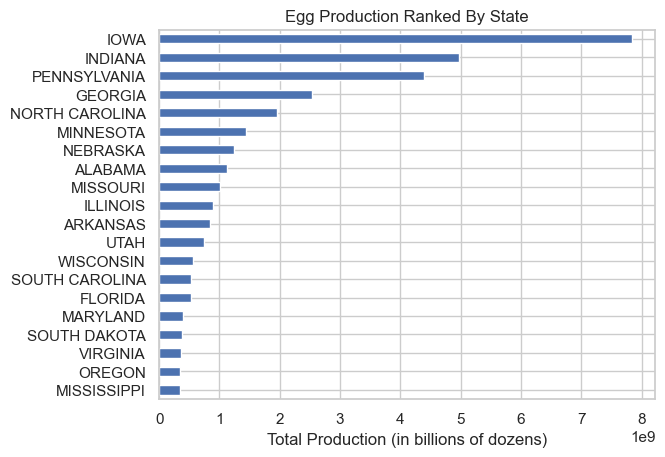

In [517]:
#new column for total production by state
joined_df['TotalStateProduction'] = joined_df.groupby('State')['Production in Dozens'].transform('sum')

#plot
top_states = joined_df.groupby('State')['TotalStateProduction'].max().sort_values(ascending=True)
pandas_plot = top_states.plot(kind='barh', x='TotalStateProduction', y='State', title='Egg Production Ranked By State')

#label x, remove y label
pandas_plot.set_xlabel('Total Production (in billions of dozens)')
pandas_plot.set_ylabel('') #label not needed

print(top_states.head(15))

Shows egg production and price fluctuations over time using Matplotlib. Year/Month columns are combined to create a single column for the x-axis. X-axis labels reduced in frequency for readability.

Findings:
- Production for the year often peaks October through December.
- Dips in production happen in Februrary/March.
- 2019 was the peak year for production.
- Prices peaked at $1.89/dozen in 2018.
- Prices change gradually compared to production.

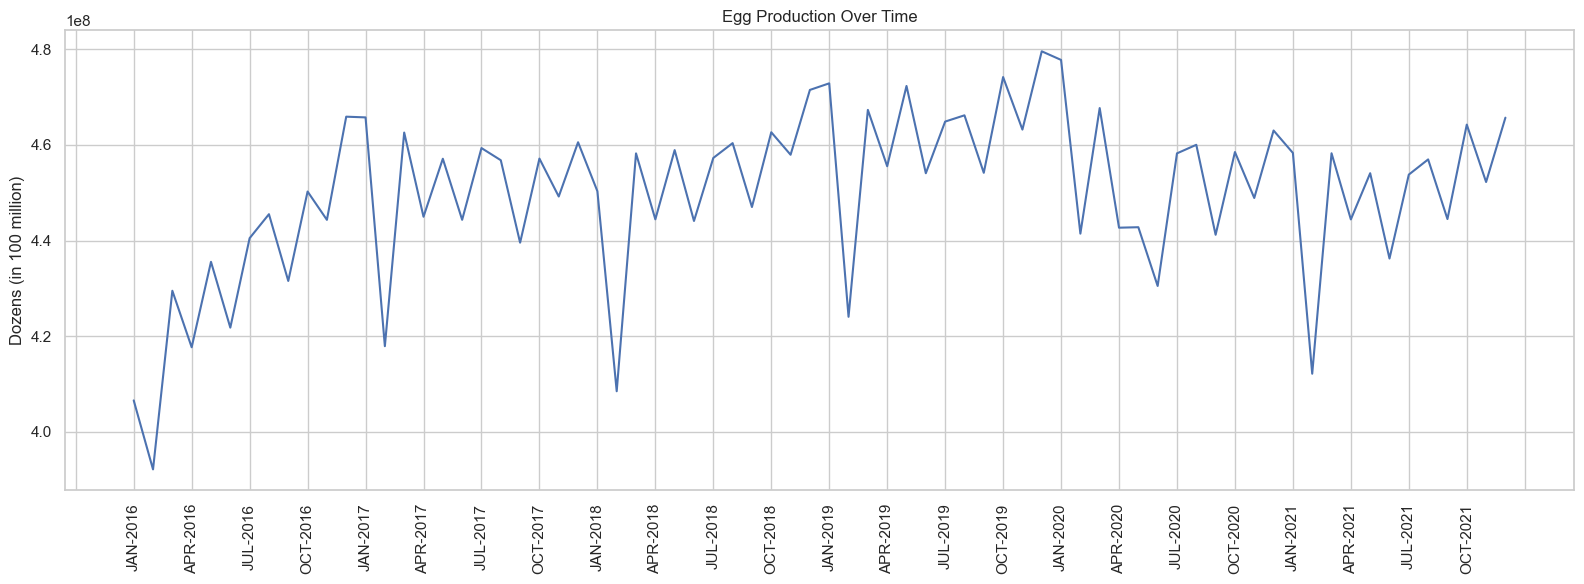

In [518]:
# new column for yearly totals
joined_df['TotalYearlyProduction'] = joined_df.groupby(['Year', 'Month'], sort=False)['Production in Dozens'].transform('sum')

# new column for combined year and month to use on x axis
joined_df['Year/Month'] = joined_df['Month'] + '-' + joined_df['Year'].astype(str)

# make plot for yearly fluctuations
plt.figure(figsize=(16, 6))
plt.plot(joined_df['Year/Month'], joined_df['TotalYearlyProduction'])

# labels and title
plt.title('Egg Production Over Time')
plt.xlabel('') #label not needed
plt.ylabel('Dozens (in 100 million)')

# make x axis readable with reduced label frequency
plt.xticks(joined_df['Year/Month'], rotation=90, ha='center')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

# display
plt.tight_layout()
plt.show()

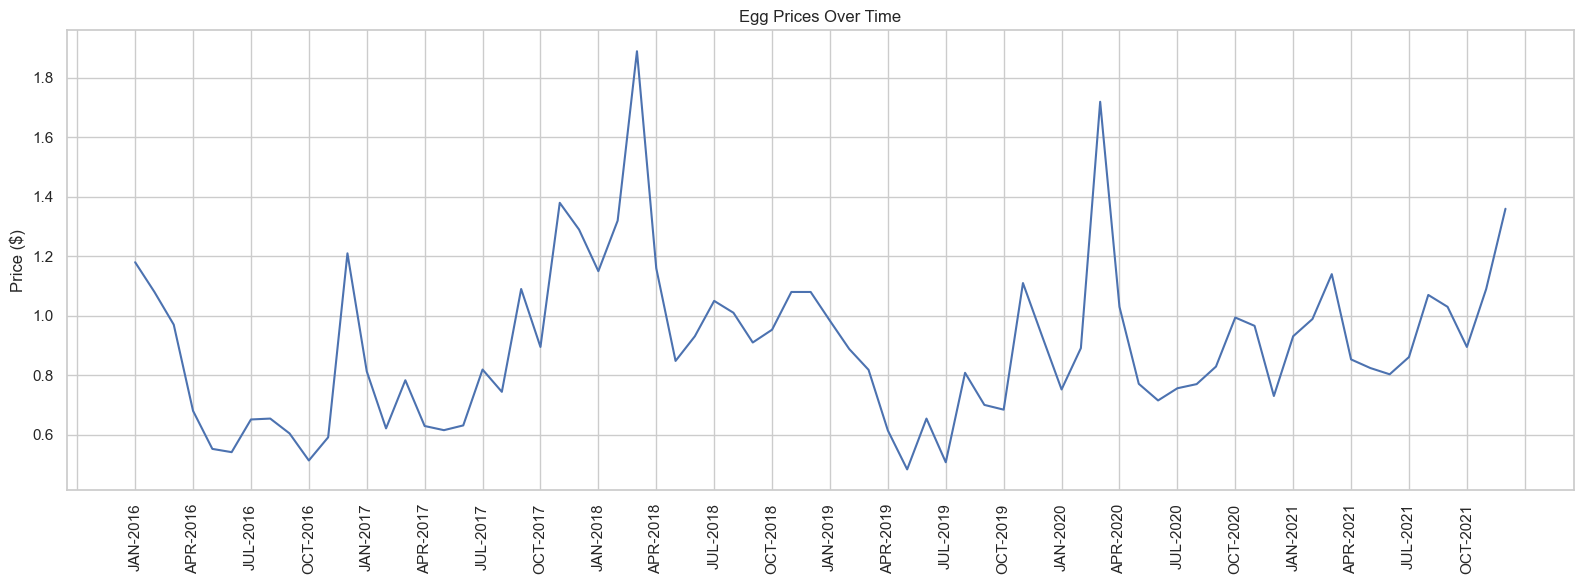

In [519]:
# aggregate mean prices by year and month into a new dataframe
monthly_prices_df = joined_df.groupby(['Year', 'Month'], sort=False)['Price($) per Dozen (All Types)'].mean().reset_index()

# create a new column for combined year and month to use on x-axis
monthly_prices_df['Year/Month'] = monthly_prices_df['Month'] + '-' + monthly_prices_df['Year'].astype(str)

# make plot for yearly fluctuations
plt.figure(figsize=(16, 6))
plt.plot(monthly_prices_df['Year/Month'], monthly_prices_df['Price($) per Dozen (All Types)'])

# labels and title
plt.title('Egg Prices Over Time')
plt.xlabel('')  # no label needed
plt.ylabel('Price ($)')

# make x-axis readable with reduced label frequency
plt.xticks(monthly_prices_df['Year/Month'], rotation=90, ha='center')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=30))

# display
plt.tight_layout()
plt.show()

National egg production is examined using Matplotlib and Geopandas to plot a heatmap for the US. A public source was used for Geopandas data. Geopandas was required because Matplotlib alone cannot produce actual maps.

Findings:
- Many states had redacted data
- Heatmap matches Top Producers visualization
- Southern US had the most complete data

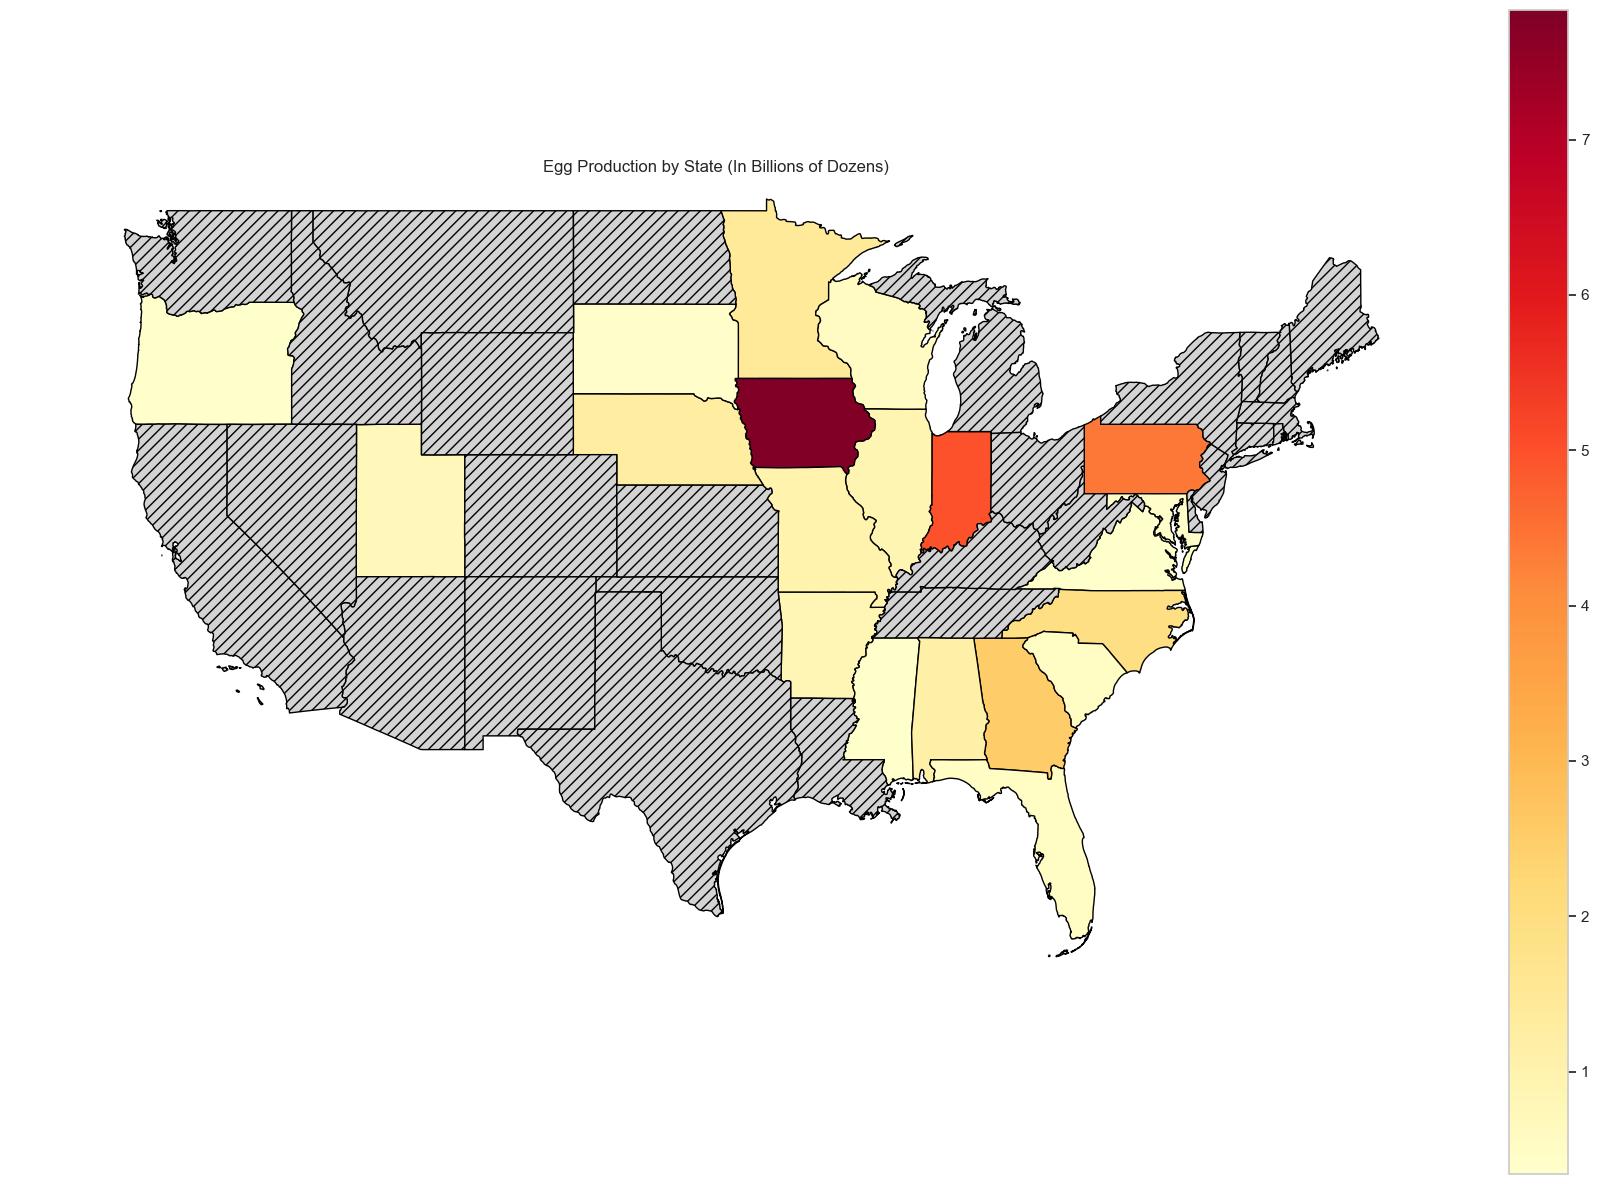

In [520]:
# set up Geopandas US map boundaries
url = 'https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json'
us_states = gpd.read_file(url)

# aggregate and scale production to billions to match bar plot/avoid confusion
production = joined_df.groupby('State')['TotalStateProduction'].max() / 1000000000
prod_df = pd.DataFrame({'State': production.index, 'Production': production.values})

# standardize state names for merging
prod_df['State'] = prod_df['State'].str.title()

# merge production data with US states GeoDataFrame (on state name)
merged = us_states.merge(prod_df, left_on='NAME', right_on='State', how='left')

# create the plot
fig, ax = plt.subplots(figsize=(18, 12))

# plot the map
merged.plot(
    column='Production', 
    cmap='YlOrRd', 
    legend=True, 
    ax=ax, 
    edgecolor='black',  # state borders
    missing_kwds={'color': 'lightgrey', 'edgecolor': 'black', 'hatch': '///'}  # style for states with no data
)

# Set plot limits to zoom into contiguous US (approximate bounds) to fix map scaling issues
ax.set_xlim(-130, -65)
ax.set_ylim(23, 50)

# title and labels
ax.set_title('Egg Production by State (In Billions of Dozens)')
ax.axis('off')  # hide axis for a clean map

plt.tight_layout()

# Display the plot with increased resolution
plt.tight_layout()
plt.show()

# Project Summary

This project examines egg production and price trends in the United States from 2016 to 2021, using data from the USDA National Agricultural Statistics Service. The analysis focuses on monthly production volumes by state and national egg prices, incorporating data cleaning, feature engineering, and visualizations to identify patterns and relationships.

Key steps included:
- Loading and cleaning datasets to handle missing or undisclosed values.
- Joining production and price data for integrated analysis.
- Creating visualizations such as line plots for price fluctuations over time and a heat map for state-level production.
- Aggregating totals to highlight top producers and seasonal variations.

## Key Findings

- **Top Producers**: Iowa leads egg production by a wide margin, followed by Indiana and Georgia, which together account for a significant portion of the country's output. Pennsylvania also ranks among the higher producers, with approximately 3.95 billion dozens over the period.
- **Seasonal Trends**: Production remains relatively stable year-round, but prices show clear patterns—peaking from October through December and dipping in February/March.
- **Price Increases**: Egg prices rose steadily, with the average increasing to $1.89/dozen in 2018 before stabilizing.
- **Regional Insights**: The heat map reveals concentration in the Midwest and Southeast, with states like Iowa and Indiana dominating table egg production.